In [ ]:
# ===============================
# 1. Libraries
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


In [ ]:
# ===============================
# 2. Load & Preprocess Dataset
# ===============================
data = load_breast_cancer()
X, y = data.data, data.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# ===============================
# Updated Helper: Run GridSearch & Record Results with Accuracy + F1
# ===============================
def tune_and_evaluate(model, params, model_name, table_cols):
    # Ask GridSearchCV to compute BOTH Accuracy and F1
    scoring = {"Accuracy": "accuracy", "F1": "f1"}
    grid = GridSearchCV(model, params, cv=5, scoring=scoring, refit="Accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)

    # Collect all results into a DataFrame
    results = pd.DataFrame(grid.cv_results_['params'])
    results["Accuracy"] = grid.cv_results_["mean_test_Accuracy"]
    results["F1 Score"] = grid.cv_results_["mean_test_F1"]

    # Get the best model
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)
    f1_test = f1_score(y_test, y_pred)

    print(f"\n🔹 {model_name} Best Params:", grid.best_params_)
    print("Test Accuracy:", acc_test)
    print("Test F1 Score:", f1_test)

    return results[table_cols + ["Accuracy", "F1 Score"]], best_model


In [ ]:
# ===============================
# 3. Hyperparameter Tuning
# ===============================

# Decision Tree
dt_params = {'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, None],
             'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}
dt_table, dt_model = tune_and_evaluate(DecisionTreeClassifier(random_state=42),
                                       dt_params, "Decision Tree", ["criterion", "max_depth"])

# AdaBoost
ada_params = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1.0]}
ada_table, ada_model = tune_and_evaluate(AdaBoostClassifier(random_state=42),
                                         ada_params, "AdaBoost", ["n_estimators", "learning_rate"])

# Gradient Boosting
gb_params = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
gb_table, gb_model = tune_and_evaluate(GradientBoostingClassifier(random_state=42),
                                       gb_params, "Gradient Boosting", ["n_estimators", "learning_rate", "max_depth"])

# XGBoost
xgb_params = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5], 'gamma':[0,1]}
xgb_table, xgb_model = tune_and_evaluate(xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
                                         xgb_params, "XGBoost", ["n_estimators","learning_rate","max_depth","gamma"])

# Random Forest
rf_params = {'n_estimators': [50, 100], 'max_depth': [None, 5], 'criterion': ['gini', 'entropy']}
rf_table, rf_model = tune_and_evaluate(RandomForestClassifier(random_state=42),
                                       rf_params, "Random Forest", ["n_estimators","max_depth","criterion"])

# Stacked Ensemble with varying parameters
stack_params = [
    {"final_estimator": LogisticRegression(max_iter=1000)},
    {"final_estimator": SVC(probability=True)},
    {"final_estimator": RandomForestClassifier(n_estimators=50, random_state=42)}
]

stack_results = []
stack_models = {}

estimators = [('svm', SVC(probability=True)), ('nb', GaussianNB()), ('dt', DecisionTreeClassifier())]

for i, params in enumerate(stack_params, 1):
    print(f"\n🔹 Stacked Ensemble Config {i}: {params['final_estimator'].__class__.__name__}")

    stack_clf = StackingClassifier(estimators=estimators, **params)
    stack_table, stack_model = tune_and_evaluate(stack_clf, {}, f"Stacked Ensemble {i}", [])

    stack_results.append(stack_table)
    stack_models[f"Stacked_{i}"] = stack_model



🔹 Decision Tree Best Params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
Test Accuracy: 0.9210526315789473
Test F1 Score: 0.9361702127659575

🔹 AdaBoost Best Params: {'learning_rate': 1.0, 'n_estimators': 100}
Test Accuracy: 0.956140350877193
Test F1 Score: 0.9659863945578231

🔹 Gradient Boosting Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Test Accuracy: 0.956140350877193
Test F1 Score: 0.9659863945578231


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:15:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔹 XGBoost Best Params: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Test Accuracy: 0.9473684210526315
Test F1 Score: 0.958904109589041

🔹 Random Forest Best Params: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 50}
Test Accuracy: 0.956140350877193
Test F1 Score: 0.9655172413793104

🔹 Stacked Ensemble Config 1: LogisticRegression

🔹 Stacked Ensemble 1 Best Params: {}
Test Accuracy: 0.9736842105263158
Test F1 Score: 0.9793103448275862

🔹 Stacked Ensemble Config 2: SVC

🔹 Stacked Ensemble 2 Best Params: {}
Test Accuracy: 0.9824561403508771
Test F1 Score: 0.9861111111111112

🔹 Stacked Ensemble Config 3: RandomForestClassifier

🔹 Stacked Ensemble 3 Best Params: {}
Test Accuracy: 0.956140350877193
Test F1 Score: 0.9655172413793104


In [ ]:
# ===============================
# 4. Collect Tables
# ===============================
print("\n📊 Table 1: Decision Tree")
display(dt_table)

print("\n📊 Table 2: AdaBoost")
display(ada_table)

print("\n📊 Table 3: Gradient Boosting")
display(gb_table)

print("\n📊 Table 4: XGBoost")
display(xgb_table)

print("\n📊 Table 5: Random Forest")
display(rf_table)

for i, table in enumerate(stack_results, 1):
    print(f"\n📊 Table: Stacked Ensemble {i}")
    display(table)



📊 Table 1: Decision Tree


,criterion,max_depth,Accuracy,F1 Score
0,gini,3.0,0.925275,0.941606
1,gini,3.0,0.925275,0.941606
2,gini,3.0,0.929670,0.944574
3,gini,3.0,0.929670,0.944574
4,gini,5.0,0.931868,0.946139
5,gini,5.0,0.938462,0.951770
6,gini,5.0,0.927473,0.941442
7,gini,5.0,0.934066,0.947111
8,gini,NaN,0.909890,0.928176
9,gini,NaN,0.925275,0.940398



📊 Table 2: AdaBoost


,n_estimators,learning_rate,Accuracy,F1 Score
0,50,0.01,0.931868,0.946115
1,100,0.01,0.934066,0.948002
2,50,0.10,0.960440,0.968663
3,100,0.10,0.962637,0.970432
4,50,1.00,0.969231,0.975651
5,100,1.00,0.973626,0.979190



📊 Table 3: Gradient Boosting


,n_estimators,learning_rate,max_depth,Accuracy,F1 Score
0,50,0.01,3,0.929670,0.945541
1,100,0.01,3,0.945055,0.956543
2,50,0.01,5,0.927473,0.943228
3,100,0.01,5,0.929670,0.944821
4,50,0.10,3,0.951648,0.961520
5,100,0.10,3,0.956044,0.965030
6,50,0.10,5,0.942857,0.954464
7,100,0.10,5,0.938462,0.951102



📊 Table 4: XGBoost


,n_estimators,learning_rate,max_depth,gamma,Accuracy,F1 Score
0,50,0.01,3,0,0.925275,0.941715
1,100,0.01,3,0,0.936264,0.949741
2,50,0.01,5,0,0.929670,0.945005
3,100,0.01,5,0,0.940659,0.953322
4,50,0.10,3,0,0.960440,0.968541
5,100,0.10,3,0,0.967033,0.973913
6,50,0.10,5,0,0.962637,0.970372
7,100,0.10,5,0,0.967033,0.973881
8,50,0.01,3,1,0.927473,0.943512
9,100,0.01,3,1,0.940659,0.953160



📊 Table 5: Random Forest


,n_estimators,max_depth,criterion,Accuracy,F1 Score
0,50,NaN,gini,0.951648,0.961730
1,100,NaN,gini,0.953846,0.963408
2,50,5.0,gini,0.951648,0.961855
3,100,5.0,gini,0.949451,0.960054
4,50,NaN,entropy,0.964835,0.971924
5,100,NaN,entropy,0.964835,0.971986
6,50,5.0,entropy,0.962637,0.970310
7,100,5.0,entropy,0.962637,0.970310



📊 Table 6: Stacked Ensemble


,Accuracy,F1 Score
0,0.971429,0.977258


In [ ]:
# ===============================
# 5. 5-Fold Cross Validation for All Models
# ===============================
models = {"Decision Tree": dt_model, "AdaBoost": ada_model, "Gradient Boosting": gb_model,
          "XGBoost": xgb_model, "Random Forest": rf_model, "Stacked": stack_model}

cv_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    cv_results[name] = list(scores) + [np.mean(scores)]

cv_table = pd.DataFrame(cv_results, index=[f"Fold {i}" for i in range(1,6)] + ["Average"])
print("\n📊 Table 7: 5-Fold Cross Validation Results")
display(cv_table)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:15:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:15:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:15:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:15:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:15:24] WARNING: /w


📊 Table 7: 5-Fold Cross Validation Results


,Decision Tree,AdaBoost,Gradient Boosting,XGBoost,Random Forest,Stacked
Fold 1,0.938596,0.991228,0.956140,0.964912,0.982456,0.973684
Fold 2,0.885965,0.938596,0.903509,0.921053,0.938596,0.956140
Fold 3,0.929825,0.956140,0.956140,0.956140,0.964912,0.947368
Fold 4,0.929825,0.973684,0.956140,0.973684,0.956140,0.964912
Fold 5,0.955752,0.973451,0.973451,0.964602,0.973451,0.964602
Average,0.927993,0.966620,0.949076,0.956078,0.963111,0.961341


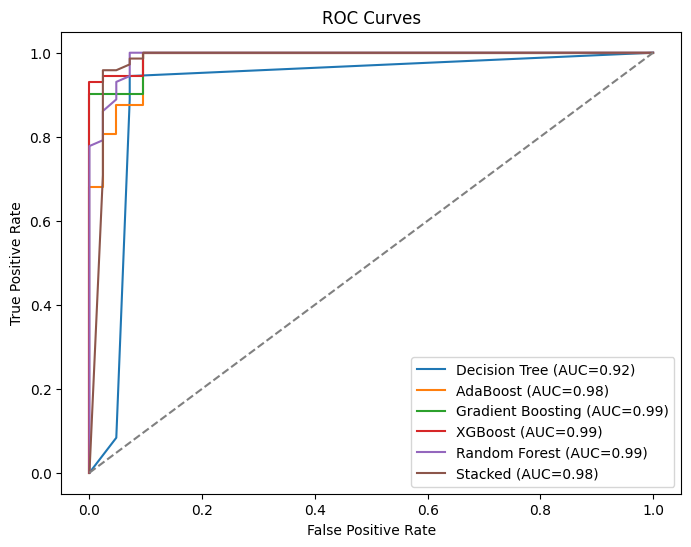

In [ ]:
# ===============================
# 6. ROC Curves
# ===============================
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves"); plt.legend(); plt.show()


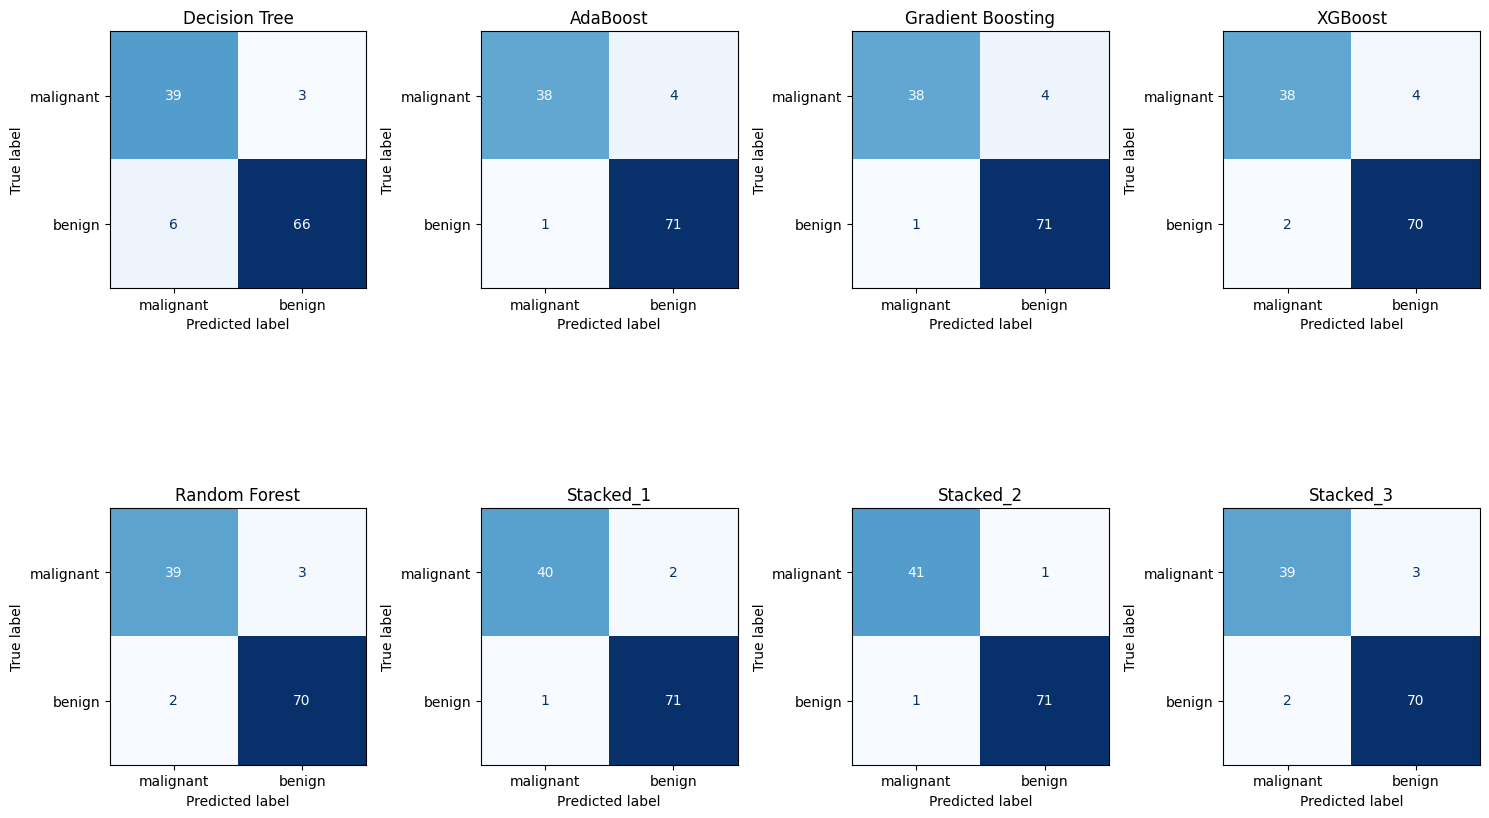

In [ ]:
# ===============================
# Confusion Matrices for Each Best Model
# ===============================
from sklearn.metrics import ConfusionMatrixDisplay

all_models = {
    "Decision Tree": dt_model,
    "AdaBoost": ada_model,
    "Gradient Boosting": gb_model,
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
}

# Add stacked ensemble variants
all_models.update(stack_models)

plt.figure(figsize=(15, 10))
for i, (name, model) in enumerate(all_models.items(), 1):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)

    plt.subplot(2, (len(all_models)+1)//2, i)
    disp.plot(cmap="Blues", ax=plt.gca(), colorbar=False)
    plt.title(name)

plt.tight_layout()
plt.show()


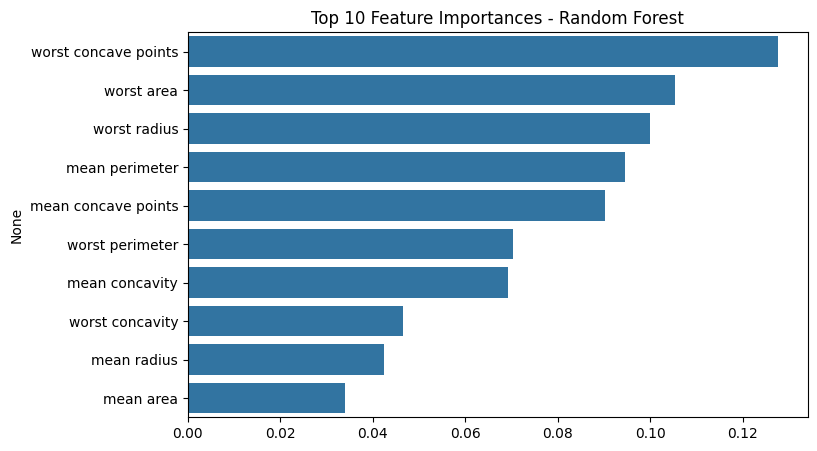

In [ ]:
# ===============================
# 7. Feature Importance (Example: Random Forest)
# ===============================
importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=data.feature_names).sort_values(ascending=False)[:10]

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 10 Feature Importances - Random Forest")
plt.show()
